In this assignment, I created a simple CNN from scratch using PyTorch to perform classification on the MNIST dataset.

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset. 
It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The specific steps are:
1. Download MNIST dataset in local system. Create a base CNN model (Conv → MaxPooling → Conv → MaxPooling → FC).
2. Train the model for 10 epochs (shuffle=True, optimizer=SGD, activation=relu, learning rate=.01).
3. Evaluate the performance of the model and report the confusion matrix and the test accuracy.
4. Update the  model by adding momentum and report the performance.
5. To explain the purpose of the learning rate.

Import the libs

In [55]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib.pyplot import MultipleLocator

In [56]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Download MNIST dataset in local system

The MNIST database contains 60,000 training images and 10,000 testing images.

PyTorch domain libraries provide a number of pre-loaded datasets that subclass torch.utils.data.Dataset and implement functions specific to the particular data. 

In [57]:
#One type of transformation that we do on images is to transform an image into a PyTorch tensor. 
# When an image is transformed into a PyTorch tensor, the pixel values are scaled between 0.0 and 1.0. 
# In PyTorch, this transformation can be done using torchvision.transforms.ToTensor()
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [58]:
print(train_data)
print(test_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


Visualization of MNIST dataset

Plot one train_data

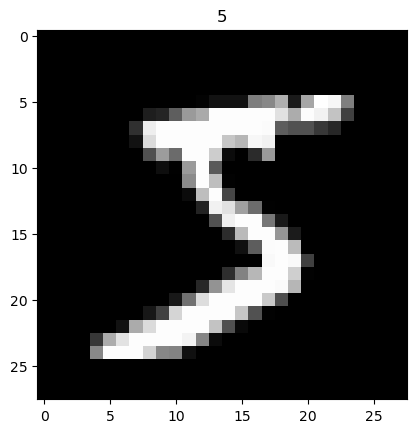

In [59]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

Plot multiple train_data

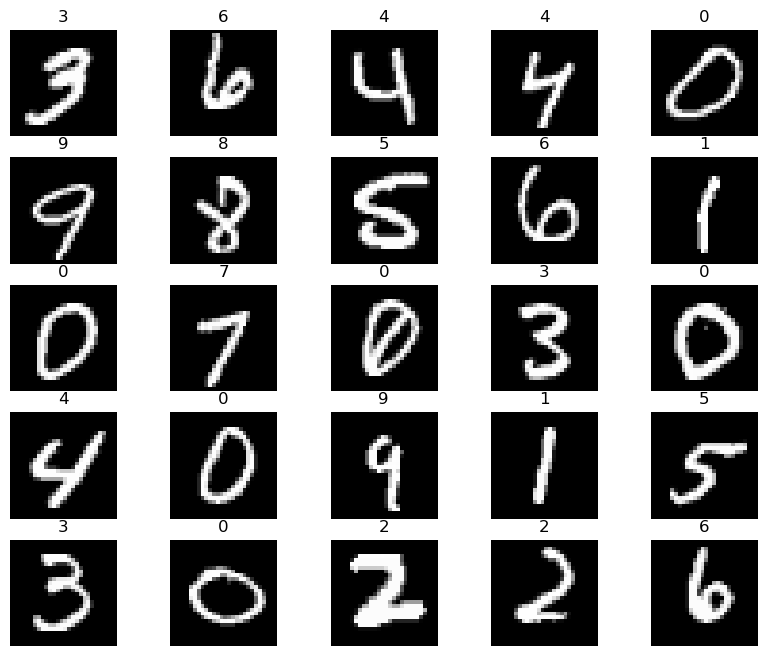

In [60]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Preparing data for training with DataLoaders

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [61]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=300, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=300, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f3a90f6dd00>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f3a90f6d9a0>}

Define the Convolutional Neural Network model

Created convolution neural network using torch.nn.Module. torch.nn.Module will be base class for all neural network modules. 
We will use 2 fully convolutional layers, Relu activation function and MaxPooling.

In [62]:
#We will use 2 fully convolutional layers, Relu activation function and MaxPooling.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,  #in_channels (int): Number of channels in the input image            
                out_channels=16, #out_channels (int): Number of channels produced by the convolution           
                kernel_size=5,   #kernel_size (int or tuple): Size of the convolving kernel            
                stride=1,       #stride (int or tuple, optional): Stride of the convolution. Default: 1             
                padding=2,      #padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0            
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2), # the output of layer 1
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        
        
        # fully connected layer, output 10 classes
        
        self.out = nn.Linear(32 * 7 * 7, 10)  #the output of layer 2
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [63]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Define loss function

In [64]:
loss_func = nn.CrossEntropyLoss()   
loss_func

#lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.
optimizer = optim.SGD(cnn.parameters(), lr = 0.01)   
optimizer

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Train the model

Created a function called train() and pass num of epochs, model and data loaders as input parameters.
num_epochs: Number of times our model will go through the entire training dataset

In [65]:
train_losses = []
train_counter = []
epochx = []

num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        count=0
        training_loss=0.0   
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]            
            loss = loss_func(output, b_y)
            training_loss += loss.item()
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()   
            count = count+1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               
                pass

        pass
        train_losses.append(training_loss/count)
        print(training_loss)
        print(count)
        epochx.append(epoch)
    
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/200], Loss: 2.1006
Epoch [1/10], Step [200/200], Loss: 1.0318
385.1108937859535
200
Epoch [2/10], Step [100/200], Loss: 0.5949
Epoch [2/10], Step [200/200], Loss: 0.4515
118.05997547507286
200
Epoch [3/10], Step [100/200], Loss: 0.3752
Epoch [3/10], Step [200/200], Loss: 0.3244
73.09524005651474
200
Epoch [4/10], Step [100/200], Loss: 0.3138
Epoch [4/10], Step [200/200], Loss: 0.2673
60.47619606554508
200
Epoch [5/10], Step [100/200], Loss: 0.3117
Epoch [5/10], Step [200/200], Loss: 0.2093
53.02676026523113
200
Epoch [6/10], Step [100/200], Loss: 0.2187
Epoch [6/10], Step [200/200], Loss: 0.2081
47.14758004248142
200
Epoch [7/10], Step [100/200], Loss: 0.2331
Epoch [7/10], Step [200/200], Loss: 0.1777
42.52705802023411
200
Epoch [8/10], Step [100/200], Loss: 0.1775
Epoch [8/10], Step [200/200], Loss: 0.1426
38.741941414773464
200
Epoch [9/10], Step [100/200], Loss: 0.1543
Epoch [9/10], Step [200/200], Loss: 0.1582
35.61924421042204
200
Epoch [10/10], Step [100/2

Evaluate the model on test data

Called model.eval() to set dropout and batch normalization layers to evaluation mode before running inference.
model.train() tells your model that you are training the model. 

In [66]:
y_pred = []
y_true = []
def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss=0
        accur=0.0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            y_pred.extend(pred_y) # Save Prediction
            #print(pred_y)
            test_labels = labels.data.cpu().numpy()
            #print(test_labels)
            y_true.extend(test_labels) # Save Truth
            accur = (pred_y == test_labels).sum().item() / float(len(test_labels))
            pass
        
        print('Test Accuracy of the model on the 10000 test images: %.2f' % (100*accur))
    
    pass

test()

Test Accuracy of the model on the 10000 test images: 98.00


Confusion matrix

[[ 971    0    1    1    0    2    3    1    1    0]
 [   0 1118    3    2    0    0    3    0    9    0]
 [   9    2  975   11    5    1    4    6   19    0]
 [   2    1    4  976    0    9    0    6   10    2]
 [   1    3    2    1  944    0    7    2    3   19]
 [   4    2    1   15    2  851    8    1    7    1]
 [   9    3    1    0    7   11  924    1    2    0]
 [   1    8   23    7    3    1    0  961    4   20]
 [   8    2    4   14    5   10    4    3  914   10]
 [   8    8    2   10   17    5    0    6    6  947]]


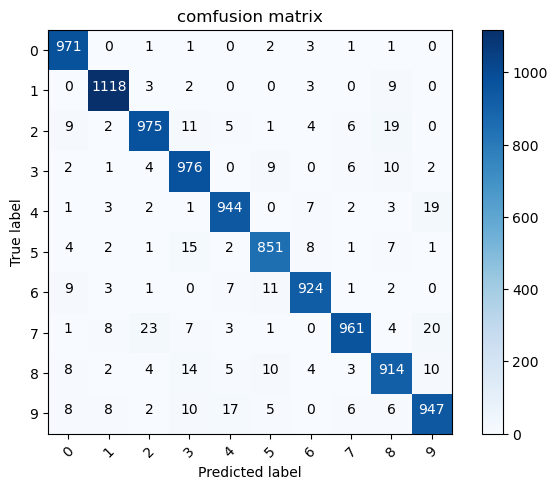

In [68]:
# constant for classes
classes = range(10)
# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
# plot the confusion matrix
classes = range(10)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('comfusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('./confusion_matrix_pytorch.jpg')

Update the model by adding momentum

Momentum is faster than stochastic gradient descent the training will be faster than SGD.
Local minima can be an escape and reach global minima due to the momentum involved.


Epoch [1/10], Step [100/200], Loss: 0.1775
Epoch [1/10], Step [200/200], Loss: 0.0781
Epoch [2/10], Step [100/200], Loss: 0.0759
Epoch [2/10], Step [200/200], Loss: 0.0931
Epoch [3/10], Step [100/200], Loss: 0.0709
Epoch [3/10], Step [200/200], Loss: 0.0578
Epoch [4/10], Step [100/200], Loss: 0.0400
Epoch [4/10], Step [200/200], Loss: 0.0734
Epoch [5/10], Step [100/200], Loss: 0.0748
Epoch [5/10], Step [200/200], Loss: 0.0449
Epoch [6/10], Step [100/200], Loss: 0.0600
Epoch [6/10], Step [200/200], Loss: 0.0663
Epoch [7/10], Step [100/200], Loss: 0.0386
Epoch [7/10], Step [200/200], Loss: 0.0496
Epoch [8/10], Step [100/200], Loss: 0.0812
Epoch [8/10], Step [200/200], Loss: 0.0291
Epoch [9/10], Step [100/200], Loss: 0.0489
Epoch [9/10], Step [200/200], Loss: 0.0256
Epoch [10/10], Step [100/200], Loss: 0.0689
Epoch [10/10], Step [200/200], Loss: 0.0169
Test Accuracy of the model by adding momentum on the 10000 test images: 99.00
[[ 977    0    0    0    0    0    1    1    1    0]
 [   0 

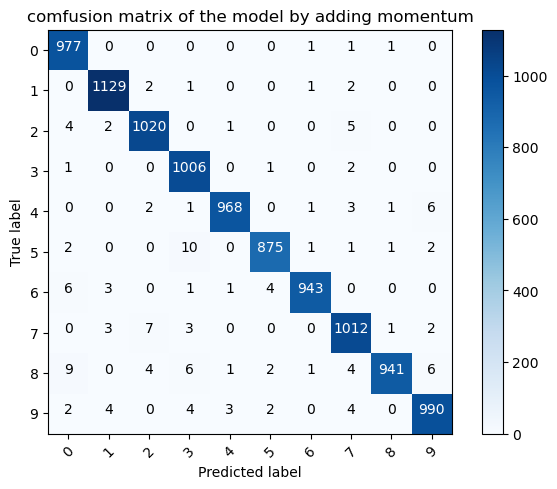

In [69]:
#lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.
#Define loss function
loss_func_momentum = nn.CrossEntropyLoss()   
loss_func_momentum

#Define a Optimization Function
optimizer_momentum = optim.SGD(cnn.parameters(), lr = 0.01,momentum=0.9)   
optimizer_momentum

#train the modle 
train_losses_momentum = []
train_counter_momentum = []

epochx_momentum = []

def train_momentum(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        count=0
        training_loss=0.0   
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]            
            loss = loss_func(output, b_y)
            training_loss += loss.item()
            count=count+1
            # clear gradients for this training step   
            optimizer_momentum.zero_grad()           
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer_momentum.step()   

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               
                pass

        pass
        train_losses_momentum.append(training_loss/count)
        epochx_momentum.append(epoch)
    
    pass
train_momentum(num_epochs, cnn, loaders)

y_pred_momentum = []
y_true_momentum = []
def test_momentum():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss=0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            y_pred_momentum.extend(pred_y) # Save Prediction
            #print(pred_y)
            test_labels = labels.data.cpu().numpy()
            #print(test_labels)
            y_true_momentum.extend(test_labels) # Save Truth 
            accur = (pred_y == test_labels).sum().item() / float(len(test_labels))
            pass
        print('Test Accuracy of the model by adding momentum on the 10000 test images: %.2f' % (100*accur))
    
    pass

test_momentum()

# constant for classes
classes = range(10)
# Build confusion matrix
cm_momentum = confusion_matrix(y_true_momentum, y_pred_momentum)
print(cm_momentum)
# plot the confusion matrix
plt.imshow(cm_momentum, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('comfusion matrix of the model by adding momentum')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm_momentum.shape[0]), range(cm_momentum.shape[1])):
    plt.text(j, i, cm_momentum[i, j],
    horizontalalignment="center",
    color="white" if cm_momentum[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('./confusion_matrix_pytorch_momentum.jpg')

Summery

From the bellow figure, we can see that the training model by adding momentum is better than the training model without momentum.

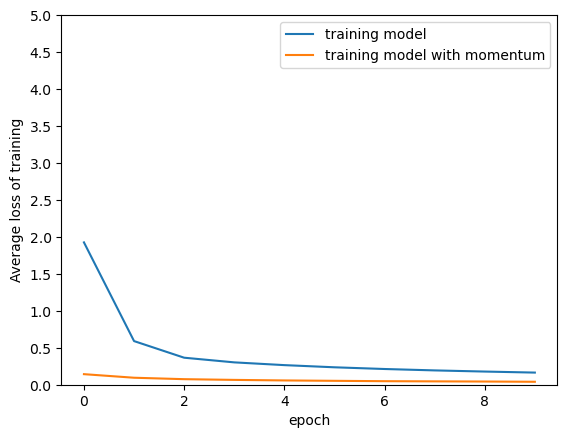

In [72]:
#plot learning rate
plt.ylim(0,5)
plt.xlabel("epoch")
plt.ylabel('Average loss of training')
yMajorLocator=MultipleLocator(0.5)
ax=plt.gca()
ax.yaxis.set_major_locator(yMajorLocator)
plt.plot(epochx,train_losses,label="training model")
plt.plot(epochx_momentum,train_losses_momentum,label="training model with momentum")
plt.legend()
plt.show()

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.
A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, 
whereas a learning rate that is too small can cause the process to get stuck.